# Experiments on $\mathcal{S}$-VAE

Author: Louis Martinez

Here we reproduce some experiments of the paper [Hyperspherical Variational Auto-Encoders](svae.pdf). We mainly focus on the synthetic experiment involving vMF distributions.

In [1]:
import os
import sys
import random
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

sys.path.append('hyperspherical_vae')
from hyperspherical_vae.distributions import VonMisesFisher, HypersphericalUniform


np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

device = 'cuda:1'

## Dataset

Following the instructions of the paper, we create a synthetic dataset with 3 vMF distributions with  different angles.  
The initial 2D data points are then projected to $\mathbb{R}^{100}$ and noised. However, the procedure used by the authors of the paper isn't detailed. Therefore, we elaborated and used the following one: 

1. We randomly choose 100 2D points $(c_1,..., c_{100}), c_i \in \mathbb{R}^2$
2. We define
\begin{align}
f: &\mathbb{R}^2\rightarrow \mathbb{R}^{100}\\
& x \mapsto \left(\exp(-\|x-c_1\|^2) + \epsilon_1, ..., \exp(-\|x-c_{100}\|^2 + \epsilon_{100})\right)^T 
\end{align}
where $\epsilon_i \sim \mathcal{N}(0,1)$

3. Now for each datapoint $x_j \sim p(x)$, $f(x_j)$ is the input of the autoencoder

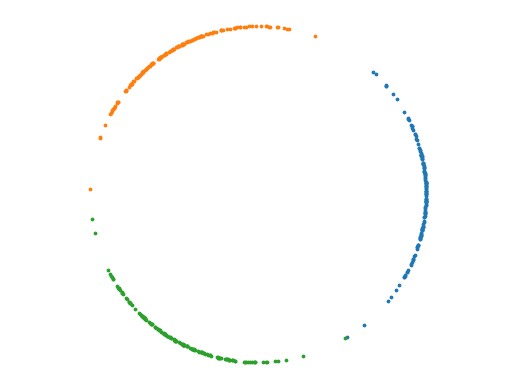

In [2]:
def gen_loc(angle):
    loc = torch.tensor([np.cos(angle), np.sin(angle)]).unsqueeze(0)
    loc = loc / loc.norm()
    return loc

def plot_samples(all_samples, save=None):
    plt.figure()
    plt.axis('off')
    plt.axis('equal')
    for samples in all_samples:
        plt.scatter(samples[:,0], samples[:,1], s=3)
    if save: plt.savefig(save)
    plt.show()

scale = torch.tensor([10.0]).unsqueeze(0)
locs = [gen_loc(i * 2 * np.pi / 3) for i in range(3)]
vmfs = [VonMisesFisher(loc=loc, scale=scale) for loc in locs]
all_samples = [vmf.rsample(150).squeeze(1) for vmf in vmfs]
plot_samples(all_samples, 'outputs/circle_original.png')

In [3]:
class DiskDataset(Dataset):

    def __init__(self, n_samples_per_cluster=150, n_clusters=3, scale=10.0, dim=100):
        self.n_samples_per_cluster = n_samples_per_cluster
        self.n_clusters = n_clusters
        self.dim = dim
        self.scale = torch.tensor([scale]).unsqueeze(0)

        locs = [gen_loc(i * np.pi * 2 / n_clusters) for i in range(n_clusters)]
        vmfs = [VonMisesFisher(loc=loc, scale=self.scale) for loc in locs]

        self.centers = 2 * torch.rand(dim, 2) - 1 # [-1,1] # 100, 2
        self.all_samples = [vmf.rsample(self.n_samples_per_cluster).squeeze(1) for vmf in vmfs]
        self.projected_samples = [torch.exp(-torch.sum((samples[:,None,:] - self.centers[None,:,:])**2, dim=-1)).float() + 0.1 * torch.randn(n_samples_per_cluster, dim) for samples in self.all_samples]
        self.merged_samples = torch.cat(self.projected_samples, dim=0) # 15000, 2
    
    def __len__(self):
        return self.n_samples_per_cluster * self.n_clusters

    def __getitem__(self, idx):
        return self.merged_samples[idx]

dataset = DiskDataset()
len(dataset)

450

## $\mathcal{N}$-VAE and $\mathcal{S}$-VAE

We reuse the code provided by the authors of the paper

In [4]:
class ModelVAE(torch.nn.Module):
    
    def __init__(self, h_dim, z_dim, activation=F.relu, distribution='normal'):
        """
        h_dim: dimension of the hidden layers
        z_dim: dimension of the latent representation
        activation: callable activation function
        distribution: string either `normal` or `vmf`, indicates which distribution to use
        """
        super(ModelVAE, self).__init__()
        
        self.z_dim, self.activation, self.distribution = z_dim, activation, distribution
        
        # 2 hidden layers encoder
        self.fc_e0 = nn.Linear(100, h_dim * 2)
        self.fc_e1 = nn.Linear(h_dim * 2, h_dim)

        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            self.fc_mean = nn.Linear(h_dim, z_dim)
            self.fc_var =  nn.Linear(h_dim, z_dim)
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            self.fc_mean = nn.Linear(h_dim, z_dim)
            self.fc_var = nn.Linear(h_dim, 1)
        else:
            raise NotImplemented
            
        # 2 hidden layers decoder
        self.fc_d0 = nn.Linear(z_dim, h_dim)
        self.fc_d1 = nn.Linear(h_dim, h_dim * 2)
        self.fc_logits = nn.Linear(h_dim * 2, 100)

    def encode(self, x):
        # 2 hidden layers encoder
        x = self.activation(self.fc_e0(x))
        x = self.activation(self.fc_e1(x))
        
        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            z_mean = self.fc_mean(x)
            z_var = F.softplus(self.fc_var(x))
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            z_mean = self.fc_mean(x)
            z_mean = z_mean / z_mean.norm(dim=-1, keepdim=True)
            # the `+ 1` prevent collapsing behaviors
            z_var = F.softplus(self.fc_var(x)) + 1
        else:
            raise NotImplemented
        
        return z_mean, z_var
        
    def decode(self, z):
        
        x = self.activation(self.fc_d0(z))
        x = self.activation(self.fc_d1(x))
        x = self.fc_logits(x)
        
        return x
        
    def reparameterize(self, z_mean, z_var):
        if self.distribution == 'normal':
            q_z = torch.distributions.normal.Normal(z_mean, z_var)
            p_z = torch.distributions.normal.Normal(torch.zeros_like(z_mean), torch.ones_like(z_var))
        elif self.distribution == 'vmf':
            q_z = VonMisesFisher(z_mean, z_var)
            p_z = HypersphericalUniform(self.z_dim - 1)
        else:
            raise NotImplemented

        return q_z, p_z
        
    def forward(self, x): 
        z_mean, z_var = self.encode(x)
        q_z, p_z = self.reparameterize(z_mean, z_var)
        z = q_z.rsample()
        x_ = self.decode(z)
        
        return (z_mean, z_var), (q_z, p_z), z, x_

## Training loop 

In [5]:
def train(model, optimizer, beta=1.0):
    epoch_loss = 0
    for batch_idx, x_mb in enumerate(loader):
            optimizer.zero_grad()
            
            _, (q_z, p_z), _, x_mb_ = model(x_mb) # [batch_size, 100]
            
            # loss_recon = nn.BCEWithLogitsLoss(reduction='none')(x_mb_, x_mb).sum(-1).mean()
            loss_recon = nn.MSELoss(reduction='none')(x_mb_, x_mb).sum(-1).mean()

            if model.distribution == 'normal':
                loss_KL = beta * torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean()
            elif model.distribution == 'vmf':
                loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).mean()
            else:
                raise NotImplemented

            loss = loss_recon + loss_KL

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    return epoch_loss

## $\mathcal{S}$-VAE 

In [6]:
batch_size = 128
h_dim = 16
z_dim = 2

dataset = DiskDataset()
loader = DataLoader(dataset, batch_size=batch_size)
modelS = ModelVAE(h_dim=h_dim, z_dim=z_dim, distribution='vmf')
optimizer = Adam(modelS.parameters(), lr=1e-3)

In [7]:
n_epochs = 300
losses = np.zeros(n_epochs)

for epoch in tqdm(range(n_epochs)):
    epoch_loss = train(modelS, optimizer)
    losses[epoch] = epoch_loss

/home/infres/lmartinez-21/mva/svae/.venv/lib/python3.12/site-packages/torch/distributions/distribution.py:56: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:15<00:00, 19.92it/s]


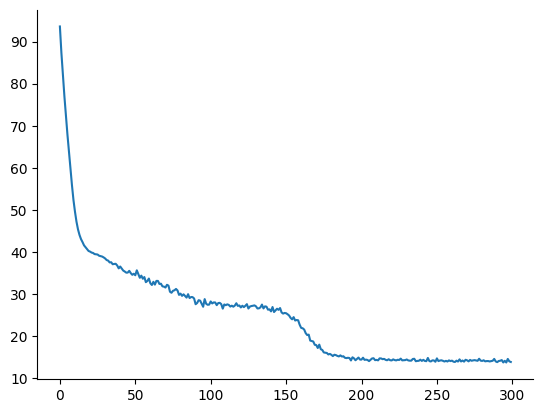

In [8]:
plt.figure()
plt.plot(losses)
plt.show()

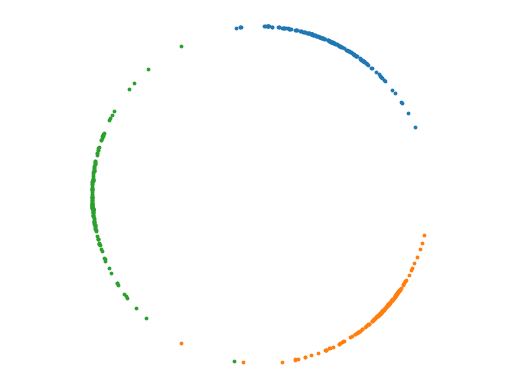

In [9]:
latents = []

modelS.eval()
with torch.no_grad():
    for sample_cluster in dataset.projected_samples:
        locs, scales = modelS.encode(sample_cluster)
        latents.append(locs)

plot_samples(latents, 'outputs/circle_svae.png')

## $\mathcal{N}$-VAE 

In [10]:
batch_size = 128
h_dim = 16
z_dim = 2

dataset = DiskDataset()
loader = DataLoader(dataset, batch_size=batch_size)
modelN = ModelVAE(h_dim=h_dim, z_dim=z_dim, distribution='normal')
optimizer = Adam(modelN.parameters(), lr=1e-3)

In [11]:
n_epochs = 300
losses = np.zeros(n_epochs)

for epoch in tqdm(range(n_epochs)):
    epoch_loss = train(modelN, optimizer, beta=1.)
    losses[epoch] = epoch_loss

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 82.50it/s]


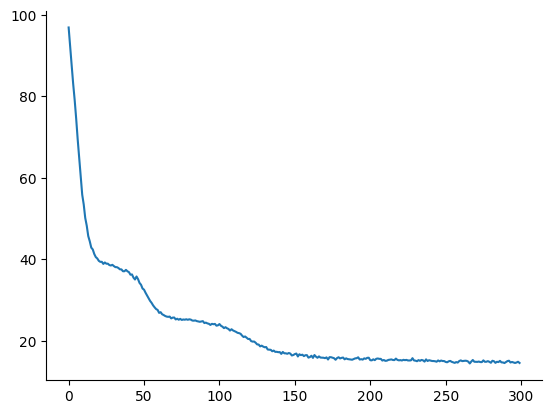

In [12]:
plt.figure()
plt.plot(losses)
plt.show()

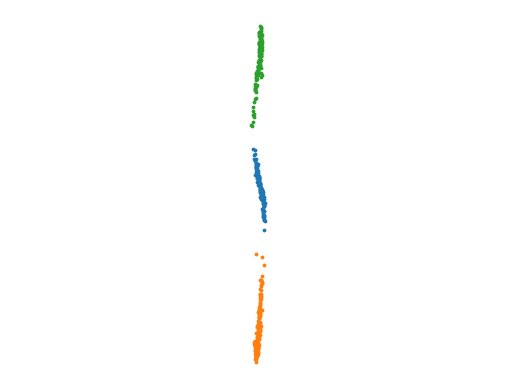

In [13]:
latents = []

modelN.eval()
with torch.no_grad():
    for sample_cluster in dataset.projected_samples:
        locs, scales = modelN.encode(sample_cluster)
        latents.append(locs)

plot_samples(latents, 'outputs/circle4_nvae')

## $\mathcal{N}$-VAE, $\beta=0.1$ 

In [14]:
batch_size = 128
h_dim = 16
z_dim = 2

dataset = DiskDataset()
loader = DataLoader(dataset, batch_size=batch_size)
modelN = ModelVAE(h_dim=h_dim, z_dim=z_dim, distribution='normal')
optimizer = Adam(modelN.parameters(), lr=1e-3)

In [15]:
n_epochs = 300
losses = np.zeros(n_epochs)

for epoch in tqdm(range(n_epochs)):
    epoch_loss = train(modelN, optimizer, beta=0.1)
    losses[epoch] = epoch_loss

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 93.42it/s]


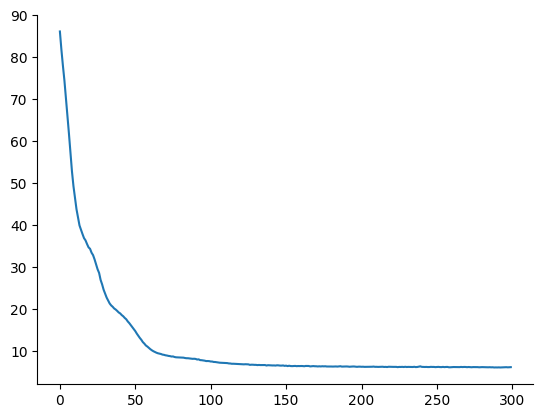

In [16]:
plt.figure()
plt.plot(losses)
plt.show()

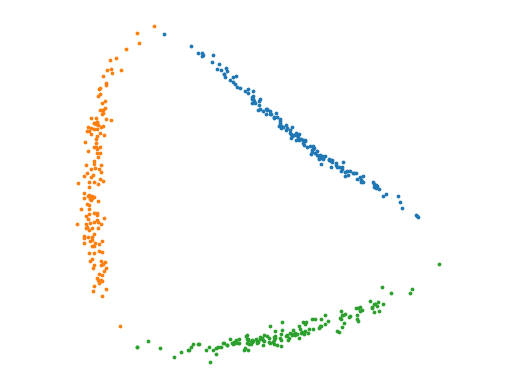

In [17]:
latents = []

modelN.eval()
with torch.no_grad():
    for sample_cluster in dataset.projected_samples:
        locs, scales = modelN.encode(sample_cluster)
        latents.append(locs)

plot_samples(latents, 'outputs/circle_nvae_beta.png')

## Legacy Auto-Encoder

In [18]:
class ModelAE(torch.nn.Module):
    
    def __init__(self, h_dim, z_dim, activation=F.relu):
        """
        ModelVAE initializer
        :param h_dim: dimension of the hidden layers
        :param z_dim: dimension of the latent representation
        :param activation: callable activation function
        """
        super().__init__()
        
        self.z_dim, self.activation = z_dim, activation
        
        # 2 hidden layers encoder
        self.fc_e0 = nn.Linear(100, h_dim * 2)
        self.fc_e1 = nn.Linear(h_dim * 2, h_dim)

        # Projection to the latent space
        self.fc_latent = nn.Linear(h_dim, z_dim)

        # 2 hidden layers decoder
        self.fc_d0 = nn.Linear(z_dim, h_dim)
        self.fc_d1 = nn.Linear(h_dim, h_dim * 2)
        self.fc_logits = nn.Linear(h_dim * 2, 100)

    def encode(self, x):
        # 2 hidden layers encoder
        x = self.activation(self.fc_e0(x))
        x = self.activation(self.fc_e1(x))
        z = self.fc_latent(x)
        return z
        
    def decode(self, z):
        x = self.activation(self.fc_d0(z))
        x = self.activation(self.fc_d1(x))
        x = self.fc_logits(x)
        return x
        
    def forward(self, x): 
        z = self.encode(x)
        out = self.decode(z)
        
        return out

In [24]:
def train(model, optimizer):
    epoch_loss = 0
    for batch_idx, x in enumerate(loader):
        optimizer.zero_grad()
        out = model(x)
        
        loss = nn.MSELoss(reduction='none')(out, x).sum(-1).mean()

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss

In [25]:
batch_size = 128
h_dim = 16
z_dim = 2

dataset = DiskDataset()
loader = DataLoader(dataset, batch_size=batch_size)
modelAE = ModelAE(h_dim=h_dim, z_dim=z_dim)
optimizer = Adam(modelAE.parameters(), lr=1e-3)

In [26]:
n_epochs = 300
losses = np.zeros(n_epochs)

for epoch in tqdm(range(n_epochs)):
    epoch_loss = train(modelAE, optimizer)
    losses[epoch] = epoch_loss

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 116.82it/s]


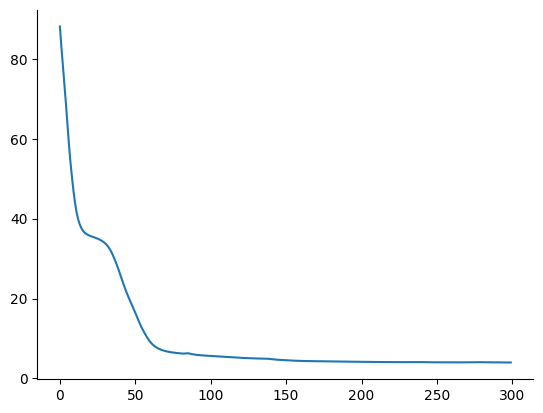

In [27]:
plt.figure()
plt.plot(losses)
plt.show()

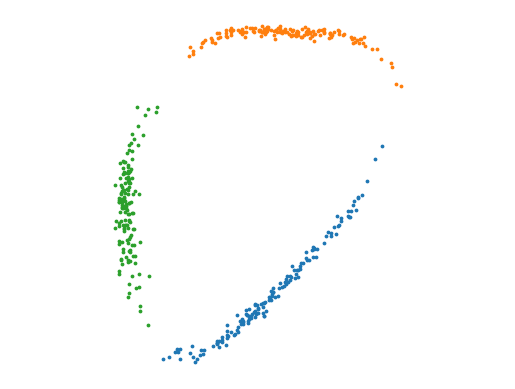

In [28]:
latents = []

modelAE.eval()
with torch.no_grad():
    for sample_cluster in dataset.projected_samples:
        locs = modelAE.encode(sample_cluster)
        latents.append(locs)

plot_samples(latents, 'outputs/circle_ae')